In [1]:
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8_49i7sz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8_49i7sz
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=136937

In [2]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [3]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [4]:
model_path

'/pretrained_models/model_wieghts.pt'

In [5]:
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)

        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [6]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [7]:
pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
  downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
else:
  downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

In [8]:
is_gpu = False #@param {type:"boolean"}

In [9]:
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 132MiB/s]


In [10]:
prefix_length = 10 # @param [8,10,14,16]

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU),strict = False)

model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

In [25]:
#@title Upload Image


uploaded = files.upload()

if not uploaded:
  UPLOADED_FILE = ''
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]
else:
  raise AssertionError('Please upload one image at a time')

print(UPLOADED_FILE)

Saving a4e1c55a9.png to a4e1c55a9.png
a4e1c55a9.png


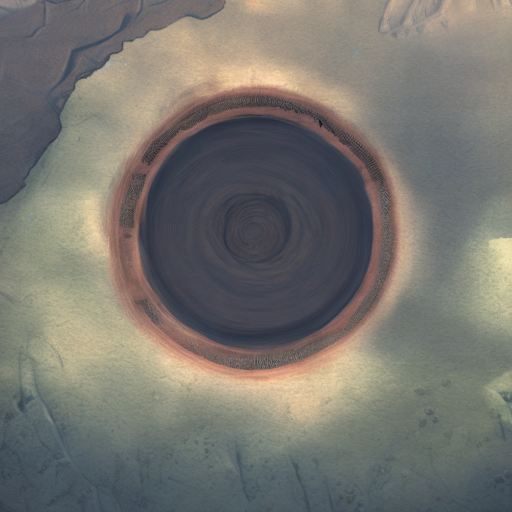



a hole in the earth.


In [12]:
#@title Inference

image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)

display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]


print('\n')
print(generated_text_prefix)

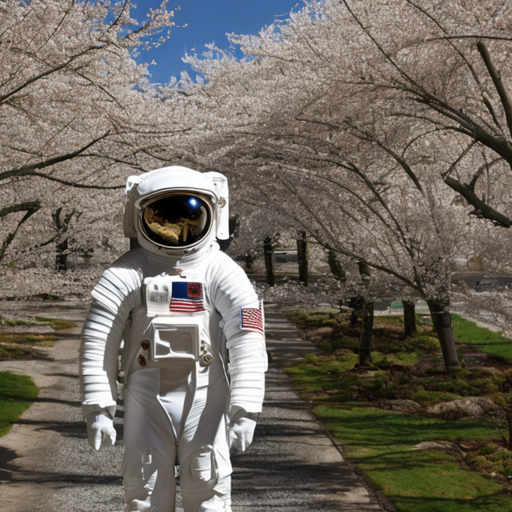



astronaut in a field of flowers.


In [23]:
image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)

display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]


print('\n')
print(generated_text_prefix)

In [16]:
import pandas as pd
df_submission = pd.read_csv( 'sample_submission.csv', index_col='imgId_eId')


In [17]:
df_submission

,val
imgId_eId,
20057f34d_0,0.018848
20057f34d_1,0.030190
20057f34d_2,0.072792
20057f34d_3,-0.000673
20057f34d_4,0.016774
...,...
f27825b2c_379,0.012124
f27825b2c_380,0.021575
f27825b2c_381,0.030563


In [18]:
prompts_df = pd.read_csv("prompts.csv")
prompts_df['generated prompt'] = " "
prompts_df['generated prompt'][1] = "this is an example of a metal plate with a circular design."
prompts_df['generated prompt'][0] = "A hole in the earth."
prompts_df['generated prompt'][2] = "A bear eating a taco."
prompts_df['generated prompt'][3]  = "A robot holding a phone in his hand."
prompts_df['generated prompt'][4]  = "portrait of a young man."
prompts_df['generated prompt'][5] = "astronaut in a field of flowers."
prompts_df['generated prompt'][6]= "i'm not sure if this is a sign or a joke, but it sure looks like a bakery."





In [19]:
prompts_df

,imgId,prompt,generated prompt
0,20057f34d,hyper realistic photo of very friendly and dys...,A hole in the earth.
1,227ef0887,"ramen carved out of fractal rose ebony, in the...",this is an example of a metal plate with a cir...
2,92e911621,ultrasaurus holding a black bean taco in the w...,A bear eating a taco.
3,a4e1c55a9,a thundering retro robot crane inks on parchme...,A robot holding a phone in his hand.
4,c98f79f71,"portrait painting of a shimmering greek hero, ...",portrait of a young man.
5,d8edf2e40,an astronaut standing on a engaging white rose...,astronaut in a field of flowers.
6,f27825b2c,Kaggle employee Phil at a donut shop ordering ...,"i'm not sure if this is a sign or a joke, but ..."


In [ ]:
pip install -U sentence-transformers


In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')



In [30]:

imgIds = [i.split('.')[0] for i in prompts_df['imgId']]

EMBEDDING_LENGTH = 384
eIds = list(range(EMBEDDING_LENGTH))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(imgIds)))]

assert sorted(imgId_eId) == sorted(df_submission.index)

In [31]:
prompts = [i for i in prompts_df['generated prompt']]
prompt_embeddings = model.encode(prompts).flatten()

submission = pd.DataFrame(
                index=imgId_eId,
                data=prompt_embeddings,
                columns=['val']).rename_axis('imgId_eId')

In [32]:
submission

,val
imgId_eId,
20057f34d_0,0.032774
20057f34d_1,0.077023
20057f34d_2,0.027711
20057f34d_3,0.060957
20057f34d_4,-0.032018
...,...
f27825b2c_379,0.011363
f27825b2c_380,0.041621
f27825b2c_381,-0.077250
